In [68]:
import utilities
import features
import librosa
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import mir_eval
import pitchspace
import itertools

Chromagram evaluation with beat-tracking </br>
-> CRP chroma

/home/max/.local/lib/python3.10/site-packages/madmom/features/downbeats.py:287: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  best = np.argmax(np.asarray(results)[:, 1])


(0.0, 20.0)

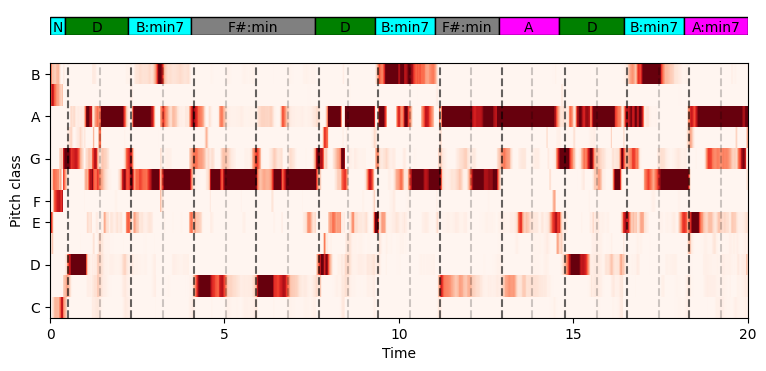

In [69]:
start = 0
stop = 20
path = "/home/max/ET-TI/Masterarbeit/mirdata/beatles/"
# title = "06_-_Rubber_Soul/11_-_In_My_Life"
# title = "12_-_Let_It_Be/06_-_Let_It_Be"
title = "10CD1_-_The_Beatles/CD1_-_17_-_Julia"

y,sr = librosa.load(path+"/audio/"+title+".wav",mono=True,offset=start,duration=stop-start,sr=22050)
target = mir_eval.io.load_labeled_intervals(path+"/annotations/chordlab/The Beatles/"+title+".lab",' ','#')

t, chroma = features.crpChroma(y,nCRP=22)
beattracking = True
try:
    if beattracking and not downbeats:
        downbeats, upbeats = features.madmom_beats(path+"/audio/"+title+".wav",2)
    else:
        downbeats = None
        upbeats = None
except NameError:
    downbeats, upbeats = features.madmom_beats(path+"/audio/"+title+".wav",2)
fig,ax = plt.subplots(2,1,height_ratios=(1,10),figsize=(9,4))
utilities.plotChordAnnotations(ax[0],target,(start,stop))
utilities.plotChromagram(ax[1],t,chroma,downbeats,upbeats);
ax[1].set_xlim(start,stop)

Complexity features

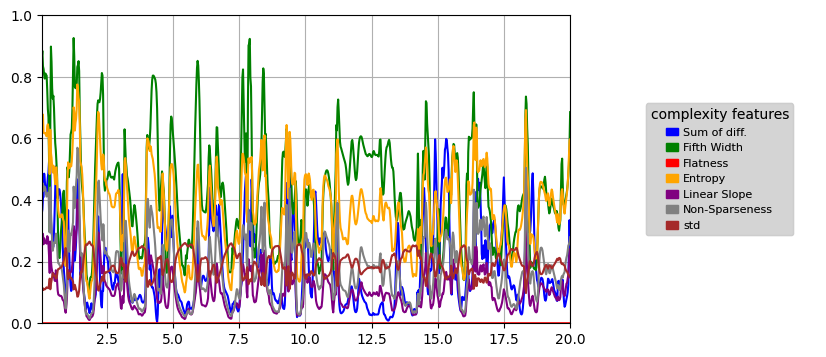

In [70]:
complexity_features = [
                features.sumChromaDifferences(chroma),
                features.angularDeviation(chroma),
                features.flatness(chroma),
                features.shannonEntropy(chroma),
                features.negativeSlope(chroma),
                features.nonSparseness(chroma),
                features.standardDeviation(chroma)
]
fig,ax = plt.subplots(1,2,width_ratios=(7.5,2.5),figsize=(10,4))
utilities.plotComplexityFeatures(ax[0],ax[1],t,complexity_features)


Key estimation with the pitch space


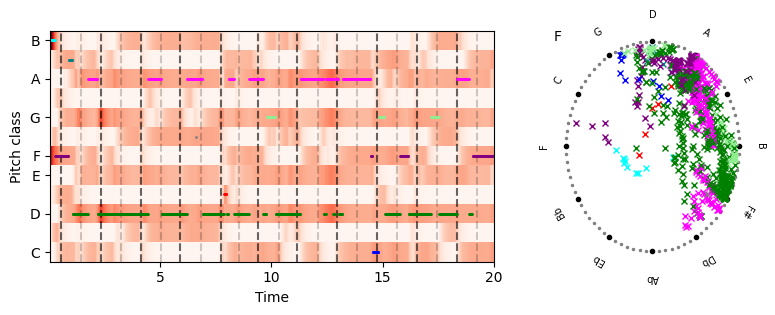

In [73]:
r_F,_,_,_ = pitchspace.transformChroma(chroma)
pc_energy = pitchspace.getPitchClassEnergyProfile(chroma,threshold=0.6,angle_weight=0.8)
pc_energy_filtered = pitchspace.filterPitchClassEnergy(pc_energy,alpha=.9)
keys = np.argmax(pc_energy_filtered,axis=1)
fig,ax = plt.subplots(1,2,width_ratios=(7,3),figsize=(9,3))
# pitch class energy can conveniently be visualized with the plotChromagram function
utilities.plotChromagram(ax[0],t,pc_energy_filtered,downbeats,upbeats)

pitchspace.plotCircleF(ax[1])
colors = ["blue","lightblue", "green", "red", "orange", "purple", "grey", "lightgreen","brown", "magenta", "teal","cyan"]
for i in range(r_F.shape[0]):
    # rotate vector for plot
    z = r_F[i] * 1j
    ax[0].plot(t[i],keys[i],'o',color=colors[keys[i]], markersize=1)
    ax[1].plot(z.real, z.imag, "x", color = colors[keys[i]],markersize=4)

Chord estimation with pitch space with a beat segment of the Chromagram

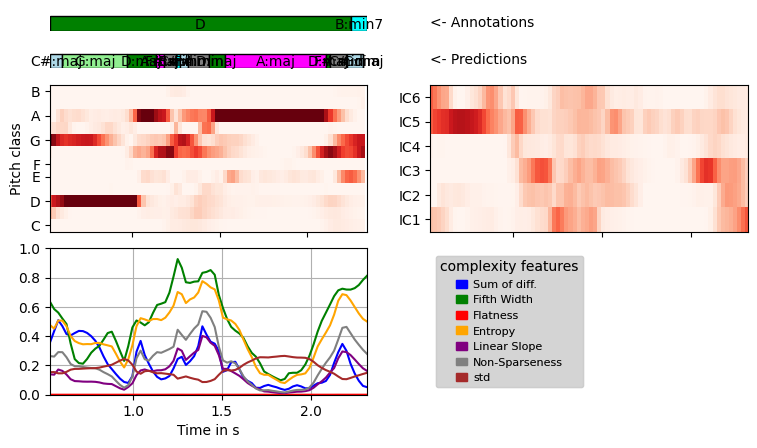

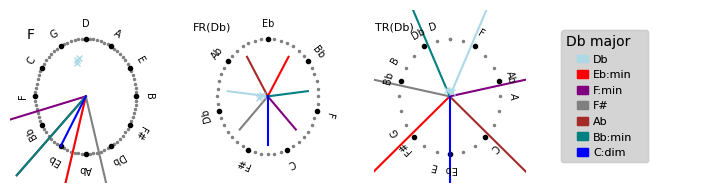

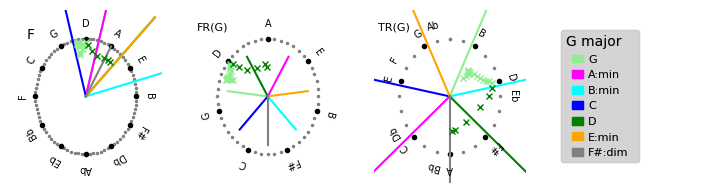

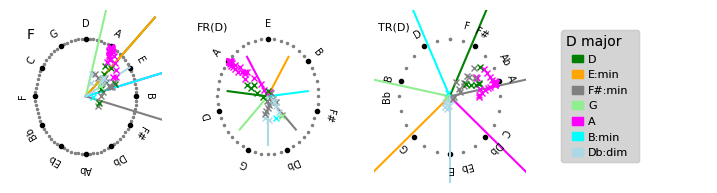

In [77]:
# split chromagram into beat segments
bar_indices = []
for beat0, beat1 in itertools.pairwise(downbeats):
    if beat0 < start:
        continue
    elif beat1 > stop:
        break
    idx0 = np.where(t >= beat0)[0][0]
    idx1 = np.where(t >= beat1)[0][0]
    bar_indices.append((idx0,idx1))

# select a bar
bar = 0
i_0 = bar_indices[bar][0]
i_1 = bar_indices[bar][1]
chroma_temp = chroma[i_0:i_1]
t_temp = t[i_0:i_1]
rho_F,rho_FR,rho_TR,rho_DR = pitchspace.transformChroma(chroma_temp)

# filter pc energy up to the selected bar!
pc_energy = pitchspace.getPitchClassEnergyProfile(chroma[:i_1],threshold=0.7,angle_weight=0.5)
pc_energy_filtered = pitchspace.filterPitchClassEnergy(pc_energy,alpha=0.96)
keys = np.argsort(pc_energy_filtered[i_0:])
keys = keys[:,-1]  # pick the most likely keys
labels = pitchspace.estimateChordLabels(t_temp, chroma_temp,keys)
est_intervals,est_labels = utilities.createChordIntervals(t_temp,labels)

complexity_features = [
                features.sumChromaDifferences(chroma_temp),
                features.angularDeviation(chroma_temp),
                features.flatness(chroma_temp),
                features.shannonEntropy(chroma_temp),
                features.negativeSlope(chroma_temp),
                features.nonSparseness(chroma_temp),
                features.standardDeviation(chroma_temp)
]
interval_categories = features.intervalCategories(chroma_temp)
# VISUALIZATION 
fig,ax = plt.subplots(4,2,height_ratios=(1,1,7,7),width_ratios=(7,7),figsize=(9,5))
utilities.plotChordAnnotations(ax[0,0],target,(t[i_0],t[i_1]))
ax[0,1].axis("off")
ax[0,1].text(0,0.2,"<- Annotations")
utilities.plotChordAnnotations(ax[1,0],(est_intervals,est_labels),(t[i_0],t[i_1]))
ax[1,1].axis("off")
ax[1,1].text(0,0.2,"<- Predictions")
utilities.plotChromagram(ax[2,0],t[i_0:i_1],chroma[i_0:i_1]);
ax[2,0].set_xlim(t[i_0],t[i_1]);
ax[2,0].set_xlabel("")
ax[2,0].set_xticklabels([])
utilities.plotIntervalCategories(ax[2,1],t_temp,interval_categories)
ax[2,1].set_xlabel("")
ax[2,1].set_xticklabels([])
utilities.plotComplexityFeatures(ax[3,0],ax[3,1],t_temp,complexity_features)
ax[3,0].set_xlabel("Time in s")

current_pitch_class = -1 # initialization
for i in range(t_temp.shape[0]):
    if current_pitch_class != keys[i]:
        current_pitch_class = keys[i]
        fig,ax = plt.subplots(1,4,figsize=(9,9/4))
        pitchspace.plotDiatonicTriads(ax,current_pitch_class)    
    z = rho_F[i] * 1j
    ax[0].plot([z.real], [z.imag], "x",color = utilities.getColor(labels[i]), markersize=5)
    z = rho_FR[i, current_pitch_class] * 1j
    ax[1].plot([z.real], [z.imag], "x",color = utilities.getColor(labels[i]), markersize=5)
    z = rho_TR[i, current_pitch_class] * 1j
    ax[2].plot([z.real], [z.imag], "x",color = utilities.getColor(labels[i]), markersize=5)